## Interactive Dashboard usind Dash and Plotly

Here is a screen shot how it will should look like in end!

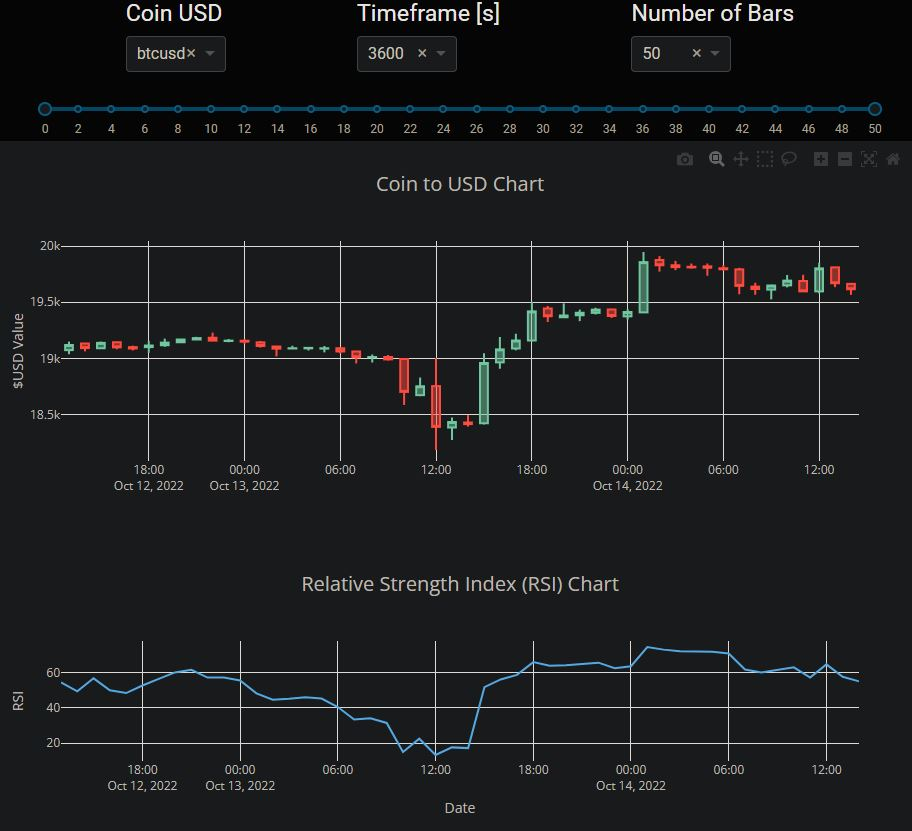
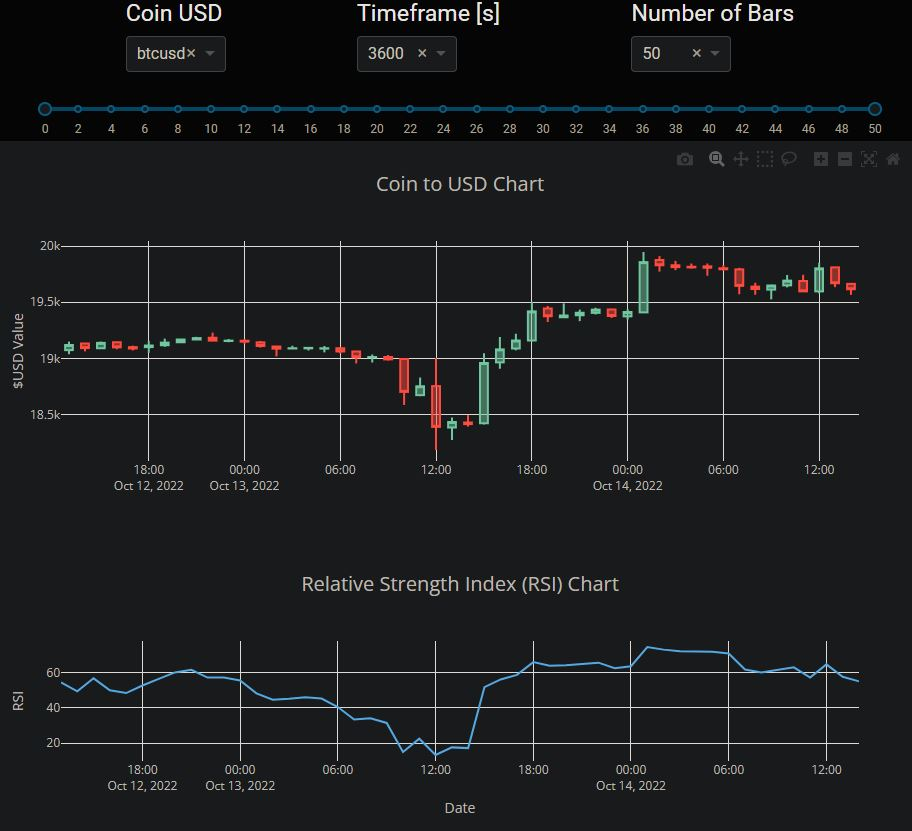

In [1]:
!pip install jupyter-dash
!pip install pyngrok
!pip install dash_bootstrap_components
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.3/745.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=b90e5e9a3c1df759d61a71ba29cba29fe98b6cdb81f574dcf38b185de63e9a7d
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 613.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=19375a2406cd21910467b228924a6eb777c33c6eea16cf9249a8c8358375a978
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85

In [2]:
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objs as go
import plotly as py

import pandas as pd
import numpy as np
import pandas_ta as ta
import requests


In [3]:
# Creating the app using Jupyter Dash 
app = JupyterDash(external_stylesheets = [dbc.themes.CYBORG])

def create_dropdown(option, id_value):

    return html.Div([html.H6(' '.join(id_value.replace('-',' ').split(' ')[:-1]),
                                style={'padding': '0px 5ßpx 0px 50px'}),
                    dcc.Dropdown(option, id=id_value, value=option[0], style={'width':'100px'})])


app.layout = html.Div([
    html.H2('Interactive Real-Time Crypto Chart', style={'margin':'auto', 'textAlign':'center', 'padding-down':'20px'}),
    html.Div([
        create_dropdown(['btcusd', 'ethusd', 'xrpusd'], 'Coin-USD-select'),
        create_dropdown(['60', '3600', '86400'], 'Timeframe-[s]-select'),
        create_dropdown(['20', '50', '100'], 'Number-of-Bars-select'),
        ], style = {'display':'flex', 'margin':'auto', 'width':'800px', 'justify-content':'space-around'}),


    html.Div([
        dcc.RangeSlider(min=0, max=20, step=1, value=[0, 20], id='range-slider'),
         ], id = 'range-slider-container',
         style = {'width':'880px', 'margin':'auto', 'padding-top':'30px'}),


    dcc.Graph(id='candles'),
    dcc.Graph(id='indicator'),
    dcc.Interval(id='interval', interval=2000),

    ])

# update the rangeslider when the interval is selected
@app.callback(
        Output('range-slider-container', 'children'),
        Input('Number-of-Bars-select', 'value')
            )

def update_Rangeslider(num_bars):
    return dcc.RangeSlider(min=0, max=int(num_bars), step=int(int(num_bars) / 20),
                           value=[0, int(num_bars)], id='range-slider')
# main callbacks
@app.callback(
        Output('candles', 'figure'),
        Output('indicator', 'figure'),
        Input('interval', 'n_intervals'),
        Input('Coin-USD-select', 'value'),
        Input('Timeframe-[s]-select', 'value'),
        Input('Number-of-Bars-select', 'value'),
        Input('range-slider', 'value'),
            )

def update_figure(n_intervals, coin_pair, time_frame, num_bars, range_values):
    url = f'https://www.bitstamp.net/api/v2/ohlc/{coin_pair}/'

    params = {
            'step': time_frame,
            # adding 14 because the rsi need a 14 days runup to be displayed
            'limit':int(num_bars)+14,
             }
    # dictonary of values
    data = requests.get(url, params=params).json()['data']['ohlc']

    # Change it to a pd.Dataframe()
    data = pd.DataFrame(data)

    # Change time to datetime for plotly to be able to pick it up
    data.timestamp = pd.to_datetime(data.timestamp, unit='s')

    # calculating the rsi
    data['rsi'] = ta.rsi(data.close.astype(float))
    # cutting the non displaing warm up bars
    data = data.iloc[14:]
    # adjusting to the range slider
    data = data.iloc[range_values[0]:range_values[1]]

    # Create a object of candlecharts
    candles = go.Figure(
                    data = [
                        go.Candlestick(
                            x=data.timestamp,
                            open = data.open,
                            high = data.high,
                            low = data.low,
                            close = data.close
                            )
                        ]
                    )
        # updating the layout and design of the figure
    candles.update_layout(xaxis_rangeslider_visible=False, height=400, template='plotly_dark'
                          , title_text='Coin to USD Chart', title_font_size=20, title_x=0.5, yaxis_title="$USD Value")

    # creating a indicator graph
    indicator = px.line(x=data.timestamp, y=data.rsi, height=300, title="Relative Strength Index (RSI) Chart"
                        , labels = {'x':'Date', 'y':'RSI'}, template='plotly_dark')
    indicator.update_layout(title_font_size=20, title_x=0.5)

    return candles, indicator


app.run_server(debug=False)


Dash app running on http://127.0.0.1:8050/


Perject the Dash App is up and running!

Idea of the code follows https://www.youtube.com/watch?v=2pdJX1kYvR4